In [1]:
import zipfile
import os

# Path to your zip file
zip_path = '/content/Rice_Image_Dataset.zip'
extract_path = '/content/Rice_Image_Dataset'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check if the extraction worked
print(os.listdir(extract_path))

['Rice_Image_Dataset']


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
img_height, img_width = 150, 150
batch_size = 32

# Create ImageDataGenerators for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Now point to the extracted directory
train_dir = '/content/Rice_Image_Dataset/Rice_Image_Dataset/train'  # Update to the correct path of your extracted folder
val_dir = '/content/Rice_Image_Dataset/Rice_Image_Dataset/test'  # Update to the correct path of your validation data

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build model
num_classes = len(train_generator.class_indices)
model = build_model(num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,036,229 (72.62 MB)

 Trainable params: 19,036,229 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=2,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 397s 207ms/step - accuracy: 0.7464 - loss: 0.6100 - val_accuracy: 0.9056 - val_loss: 0.2351
Epoch 2/2


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9583 - val_loss: 0.1247


In [5]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9091 - loss: 0.2248
Validation Loss: 0.2349032610654831
Validation Accuracy: 0.9056666493415833


In [7]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_labels = list(train_generator.class_indices.keys())
    return class_labels[class_idx]

# Predict new image
new_image_path = '/content/Basmati.jpeg'  # Replace with your image path
predicted_class = predict_image(new_image_path)
print(f'Predicted Class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicted Class: Ipsala


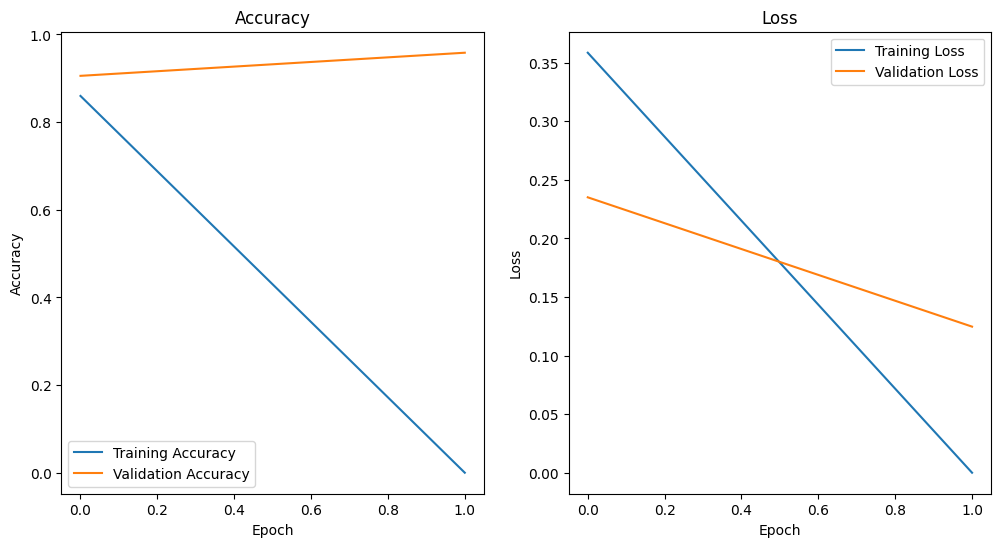

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_finetuned_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build fine-tuned model
fine_tuned_model = build_finetuned_model(num_classes=5)
fine_tuned_model.summary()

# Train fine-tuned model
history_fine_tuned = fine_tuned_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=4,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Evaluate fine-tuned model
val_loss, val_accuracy = fine_tuned_model.evaluate(val_generator)
print(f'Validation Loss (Fine-Tuned): {val_loss}')
print(f'Validation Accuracy (Fine-Tuned): {val_accuracy}')

<ipython-input-11-d234a7753ec8>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 75, 75, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 75, 75, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 75, 75, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 75, 75, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 75, 75, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 75, 75, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 75, 75, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 75, 75, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 75, 75, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 77, 77, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 38, 38, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,574,853 (13.64 MB)

 Trainable params: 1,316,869 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 408s 212ms/step - accuracy: 0.8922 - loss: 0.2975 - val_accuracy: 0.9738 - val_loss: 0.0768
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.1041
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 426s 207ms/step - accuracy: 0.9585 - loss: 0.1158 - val_accuracy: 0.9754 - val_loss: 0.0749
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0519
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9764 - loss: 0.0743
Validation Loss (Fine-Tuned): 0.07482786476612091
Validation Accuracy (Fine-Tuned): 0.9753999710083008


469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step


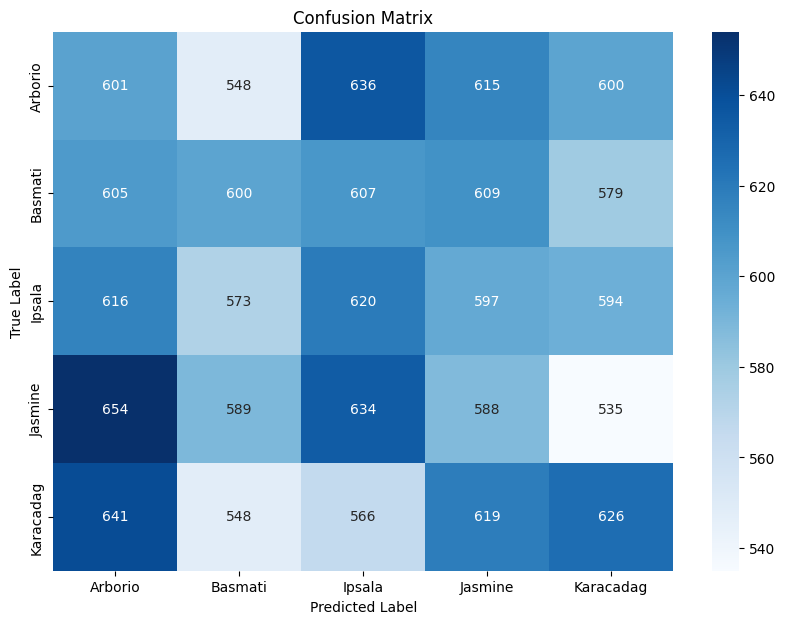

<ipython-input-14-37ac484da879>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df, palette='viridis')


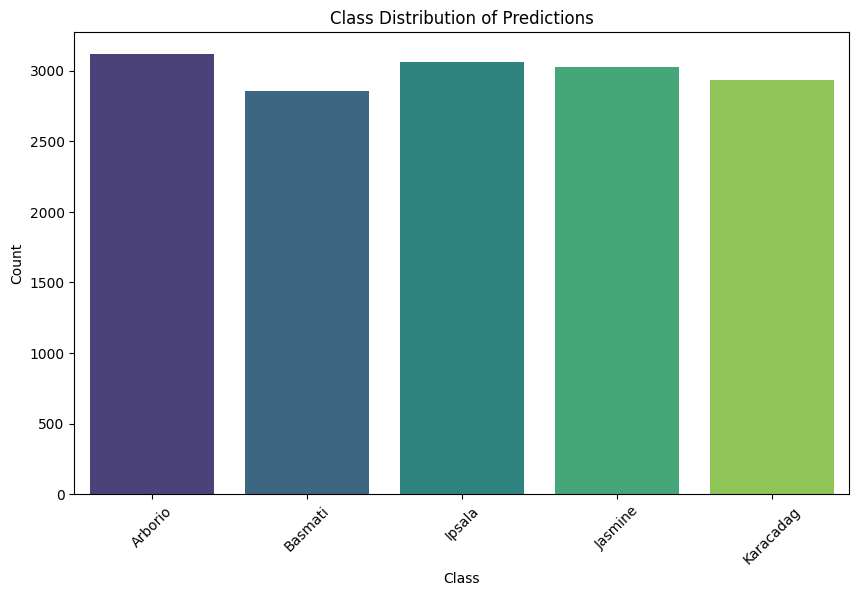

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_class_distribution(predictions, class_names):
    unique, counts = np.unique(predictions, return_counts=True)
    class_distribution = dict(zip(class_names, counts))

    df = pd.DataFrame(list(class_distribution.items()), columns=['Class', 'Count'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Count', data=df, palette='viridis')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution of Predictions')
    plt.xticks(rotation=45)
    plt.show()

# Make predictions on validation set
val_predictions = fine_tuned_model.predict(val_generator)
val_predictions_classes = np.argmax(val_predictions, axis=1)
val_true_classes = val_generator.classes

# Compute confusion matrix
cm = confusion_matrix(val_true_classes, val_predictions_classes)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names=list(train_generator.class_indices.keys()))

# Plot class distribution
plot_class_distribution(val_predictions_classes, class_names=list(train_generator.class_indices.keys()))